# Calibrating the cloud clearing algorithm
The goal with the cloud clearing algorithm is to filter out areas where the cloud cover is too thick for any ice to be retrieved. This is a two-step process with multiple adjustable parameters: first all cloudy pixels are selected and added to the mask, then cloudy pixels that are likely to have visible ice are removed from the mask. Both steps use thresholds for intensity values channel 1 and channel 2 of the MODIS false color imagery. 

Let the intensity value of channel $i$ be given by $l_i$. The module then creates a binary mask with the following steps:
1. Mask all pixels with $l_1 > 110 = \tau_c$.
2. Unmask pixels with $l_1 < 200 = \tau_1$ and $l_2 > 190 = \tau_2$.
3. Unmask pixels with $l_1/l_2 < 0.75 = \tau_r$.

We evaluate the algorithm in two parts. First, we search for an optimum value for the cloud threshold $T_C$. Presently, the manual estimate of cloud fraction is our best estimate of the "truth" for the total cloud fraction $F$. The fraction of pixels with $l_1 > T_C$ is the estimated total cloud fraction $\hat{F}$. We select 2/3 of the data at random as the training dataset. To this subset, we apply $k$-fold cross validation, optimizing the choice of cloud threshold across $T_C = 0, 10, 20, \cdots, 200$. After computing RMSE for each choice of $T_C$, we find a best-fit quadratic interpolant and find the minimizing integer value of $T_C$. The optimal choice of $T_C$ is the average across the $k$ folds. We also report the mean $RMSE$ across the $k$ folds. Finally, we calculate the error in the cloud fraction relative to the remaining 1/3 of the data.

In [13]:
import numpy as np
import os
import pandas as pd
import proplot as pplt
import rasterio as rio
from rasterio.plot import reshape_as_image
from sklearn.model_selection import KFold
from scipy.interpolate import interp1d

# Load the list of cloud clearing evaluation cases
dataloc = '../../eval_seg/'
df = pd.read_csv(dataloc + '/data/metadata/merged_validation_table.csv')
df['case_number'] = [str(cn).zfill(3) for cn in df['case_number']]
df.groupby('region').count()

,case_number,start_date,center_lon,center_lat,center_x,center_y,month,sea_ice_fraction,mean_sea_ice_concentration,init_case_number,...,visible_floes,cloud_fraction_manual,cloud_category_manual,artifacts,qa_analyst,qa_reviewer,fl_analyst,fl_reviewer,psd_file,notes
region,,,,,,,,,,,,,,,,,,,,,
baffin_bay,42,42,42,42,42,42,42,42,42,42,...,42,42,42,42,42,28,24,10,24,5
barents_kara_seas,42,42,42,42,42,42,42,42,42,42,...,42,42,42,42,42,24,6,6,2,5
beaufort_sea,42,42,42,42,42,42,42,42,42,42,...,42,42,42,42,42,26,11,6,10,4
bering_chukchi_seas,42,42,42,42,42,42,42,42,42,42,...,42,42,42,42,42,30,8,2,0,14
east_siberian_sea,42,42,42,42,42,42,42,42,42,42,...,42,42,42,42,42,38,6,2,0,25
greenland_sea,42,42,42,42,42,42,42,42,42,42,...,42,42,42,42,42,26,16,4,0,6
hudson_bay,42,42,42,42,42,42,42,42,42,42,...,42,42,42,42,42,19,4,2,0,8
laptev_sea,42,42,42,42,42,42,42,42,42,42,...,42,42,42,42,42,26,8,2,0,2
sea_of_okhostk,42,42,42,42,42,42,42,42,42,42,...,42,40,40,40,40,38,4,0,0,11


In [14]:
df['start_date'] = pd.to_datetime(df['start_date'].values)
df.index = [cn + '_' + sat for cn, sat in zip(df.case_number, df.satellite)]

def fname(case_data, imtype='labeled'):
    """Generates filenames from rows in the overview table. imtype can be "labeled", "truecolor", 
    or "falsecolor"."""

    cn = case_data['case_number']
    date = pd.to_datetime(case_data['start_date']).strftime('%Y%m%d')
    region = case_data['region']
    sat = case_data['satellite']
    if imtype=='labeled':
        return  '-'.join([cn, region, date, sat, 'labeled_floes.png'])
        
    elif imtype in ['truecolor', 'falsecolor', 'cloudfraction']:
        prefix = '-'.join([cn, region, '100km', date])
        return '.'.join([prefix, sat, imtype, '250m', 'tiff'])
for row, data in df.iterrows():
    fname(data)
    break

In [15]:
os.listdir('../../eval_seg/')
dataloc

'../../eval_seg/'

In [43]:
# Load raster data
fc_dataloc = dataloc + 'data/modis/falsecolor/'
cl_dataloc = dataloc + 'data/modis/cloudfraction/'
lb_dataloc = dataloc + 'data/validation_images/labeled_floes/'

fc_images = {}
cl_images = {}
lb_images = {}

missing = []
for row, data in df.iterrows():
    
    for datadir, imtype, data_dict in zip([fc_dataloc, cl_dataloc],
                                          ['falsecolor', 'cloudfraction'],
                                          [fc_images, cl_images]):
        try:
            with rio.open(datadir + fname(df.loc[row,:], imtype)) as im:
                data_dict[row] = im.read()
        except:
            print('Couldn\'t read', fname(df.loc[row,:], imtype), imtype)
            if fname(df.loc[row,:], imtype) not in missing:
                missing.append(fname(df.loc[row,:]))

    if data.visible_floes != 'no':
        try:
            with rio.open(lb_dataloc + fname(df.loc[row,:], 'labeled')) as im:
                lb_images[row] = im.read()
        except:
            # print('Couldn\'t read', fname(df.loc[row,:], 'labeled'))
            if fname(df.loc[row,:], imtype) not in missing:
                missing.append(fname(df.loc[row,:]))        

/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


'../../eval_seg/data/validation_images/labeled_floes/'

# Validation against the manual estimate of cloud fraction

In [17]:
# Compute estimated cloud fraction for a range of threshold values
cloud_cases = df.dropna(subset='cloud_fraction_manual').index
TC = np.linspace(0, 200, 21)
df_est_tc = pd.DataFrame(index=cloud_cases,
                          columns=TC, data=np.nan)
# for each value, compute an estimated cloud fraction based on the fc_images
for tc in df_est_tc.columns:
    for case in df_est_tc.index:
        df_est_tc.loc[case, tc] = np.mean(fc_images[case][0,:,:] > tc)

# finally, calculate the difference between F and F_est
df_err = (df_est_tc.T - df.loc[cloud_cases, 'cloud_fraction_manual']).T

In [18]:
df_training = df_err.sample(frac=2/3, replace=False, random_state=306)
df_testing = df_err.loc[[x for x in df_err.index if x not in df_training.index]]

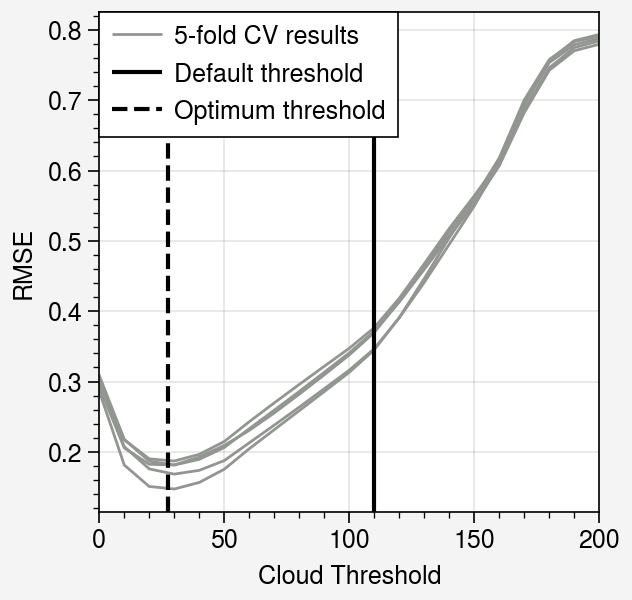

In [19]:
# Test version without splitting by regions to get syntax
fig, ax = pplt.subplots()
x_eval = np.linspace(TC.min(), TC.max(), 201)
results = []

# Initialize cross validation
# TBD: learn how to stratify within the K-fold samplng
kf = KFold(n_splits=5, random_state=20240126, shuffle=True)

for i, (train_index, test_index) in enumerate(kf.split(df_training)):
    # first get the root mean square error as a function of TC
    rmse = np.sqrt(np.mean( df_training.iloc[train_index,:]**2, axis=0))
    
    # then find the minimum
    tc_optimal = pd.Series(interp1d(x=rmse.index, y=rmse.values, kind='quadratic')(x_eval), index=x_eval).idxmin()

    test_cases = df_training.iloc[test_index, :].index
    test_results = np.array([
        np.mean(fc_images[case][0,:,:] > tc_optimal) - df.loc[case, 'cloud_fraction_manual']
            for case in test_cases])
    tc_rmse = np.sqrt(np.mean(test_results**2))
    results.append([tc_optimal, tc_rmse])
    
    ax.plot(rmse, label='', color='gray', lw=1) #label='k=' + str(i))
ax.plot([],[], color='gray', lw=1, label='5-fold CV results')
kfold_results = pd.DataFrame(results, columns=['TC', 'RMSE']).mean(axis=0).round(2)

ax.axvline(110, color='k', label='Default threshold')
ax.axvline(kfold_results['TC'], color='k', ls='--', label='Optimum threshold')
ax.format(ylabel='RMSE', xlabel='Cloud Threshold')
ax.legend(loc='ul', ncols=1, alpha=1)

# fig.save('../figures/cloud_fraction_calibration_manual.png', dpi=300)

In [20]:
kfold_results = pd.DataFrame(results, columns=['TC', 'RMSE'])
kfold_results

,TC,RMSE
0,28.0,0.138538
1,25.0,0.145328
2,30.0,0.193421
3,27.0,0.253345
4,27.0,0.104902


In [21]:
kfold_results.mean(axis=0).round()

TC      27.0
RMSE     0.0
dtype: float64

In [22]:
# Error against the held-out data
tc = 27
test_results = np.array([
    np.mean(fc_images[case][0,:,:] > tc) - df.loc[case, 'cloud_fraction_manual']
        for case in df_testing.index])
test_results = pd.Series(test_results, index=df_testing.index)
tc_rmse = np.sqrt(np.mean(test_results**2))
print('CF error:', np.round(tc_rmse, 3))

CF error: 0.23


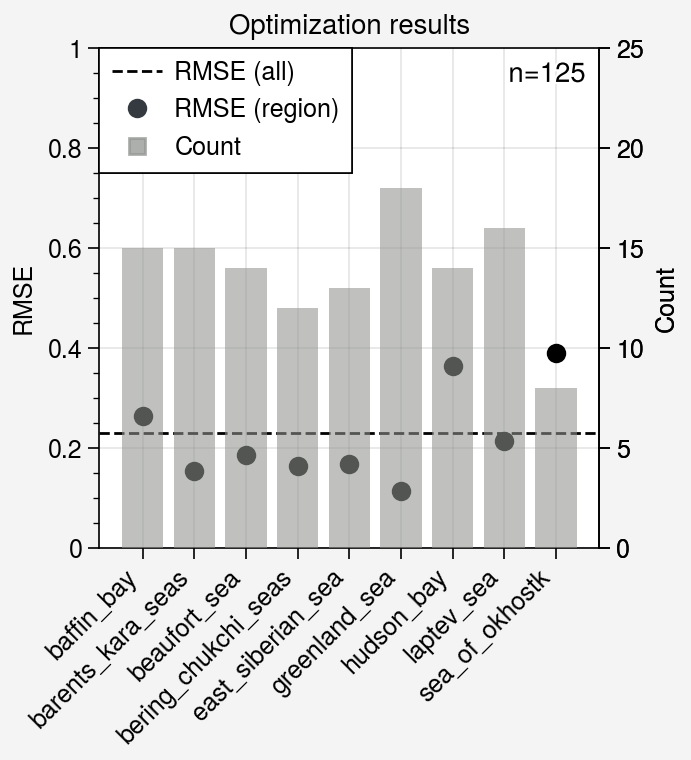

In [24]:
fig, ax = pplt.subplots()
ax.plot(
    test_results.groupby(df.loc[test_results.index, 'region']).apply(lambda x: np.sqrt(np.mean(x**2))),
    marker='o', lw=0, zorder=2, color='k')
ax.axhline(tc_rmse, color='k', ls='--', lw=1)
ax2 = ax.twinx()
ax2.bar(
    test_results.groupby(df.loc[test_results.index, 'region']).count(), zorder=0, color='gray', alpha=0.35
    )
ax2.format(ylabel='Count', ytickminor=False)

ax.format(xrotation=45, ylim=(0, 1), xlabel='', ylabel='RMSE', title='Optimization results')
ax.format(urtitle='n=' + str(len(test_results)))
ax2.format(ylim=(0, 25))
h = [ax.plot([],[],marker='', ls='--', color='k', lw=1),
     ax.plot([],[],marker='o', color='gray8', lw=0),
     ax.plot([],[],marker='s', color='gray', alpha=0.75, lw=0)]
ax2.legend(h, ['RMSE (all)', 'RMSE (region)', 'Count'], loc='ul', ncols=1, alpha=1)
# fig.save('../figures/cloud_fraction_validation_manual.png', dpi=300)

# Results
Based on the manual cloud fraction data, the optimal choice of the cloud threshold $T_C$ is 35, with an associated error of 16.5%. The visualization of the RMSE function for the 5-fold cross validation shows that the threshold choice varies only slightly between samples, and that the variability in RMSE abetween regions is not particularly large. Error is highest in the Beaufort Sea and lowest in the Barents-Kara Seas.

# Questions
- Is it better to over or underestimate cloud fraction?
- Is this low threshold overly aggressive?
- How does the error look spatially?
- How does the manual cloud fraction compare to the MODIS cloud mask, which is likely more precise?
- How does the manual cloud fraction compare with ERA5, CERES cloud fractions? (e.g.)
- Can I wrap together the parts of the k-fold validation using cleaner arrangements? E.g. using recommended functions from the docs.
- Is there a tendency toward a particular kind of error w/ e.g. thin clouds, land, different cloud fractions?

# Callibration using the MODIS cloud product


To calibrate the cloud mask against the MODIS cloud product, I translated the RGB data into percentages. The percentages are only known to the nearest ~16%. The percentage represent the number of pixels in a block that are flagged as clouds. The mean of the difference between the binary cloud-flagged pixels and the cloud fraction matrix is equal to the difference in mean cloud fraction.

For a matrix $A$ with binary data, we can think of it as consisting of blocks:
$$
\left[
\begin{matrix}
a_{00} & a_{01} \\
a_{10} & a_{11}
\end{matrix}
\right]
$$
where the individual blocks may look like
$$a_{00} = 
\left[
\begin{matrix}
 0 & 1 & 0 \\
 1 & 0 & 1 \\
 1 & 0 & 1 
\end{matrix}
\right]
$$
The mean of $a_{00}$ in this example is $\bar a = 5/9$. The cloud fractions from MODIS are going to be the same shape as the matrix, but with constant values within each block e.g.
$$b_{00} = 
\left[
\begin{matrix}
 f & f & f \\
 f & f & f \\
 f & f & f 
\end{matrix}
\right]
$$
Thus the mean of the block difference $a_{00} - b_{00}$ is simply the difference in fractions:
$$ \frac{1}{9}(-4f + 5(1-f)) = \frac{1}{9}(5 - 9f) = \bar a - f$$

If $f = \bar a$, then we have
$$\langle a_{00} - b_{00} \rangle = 0$$

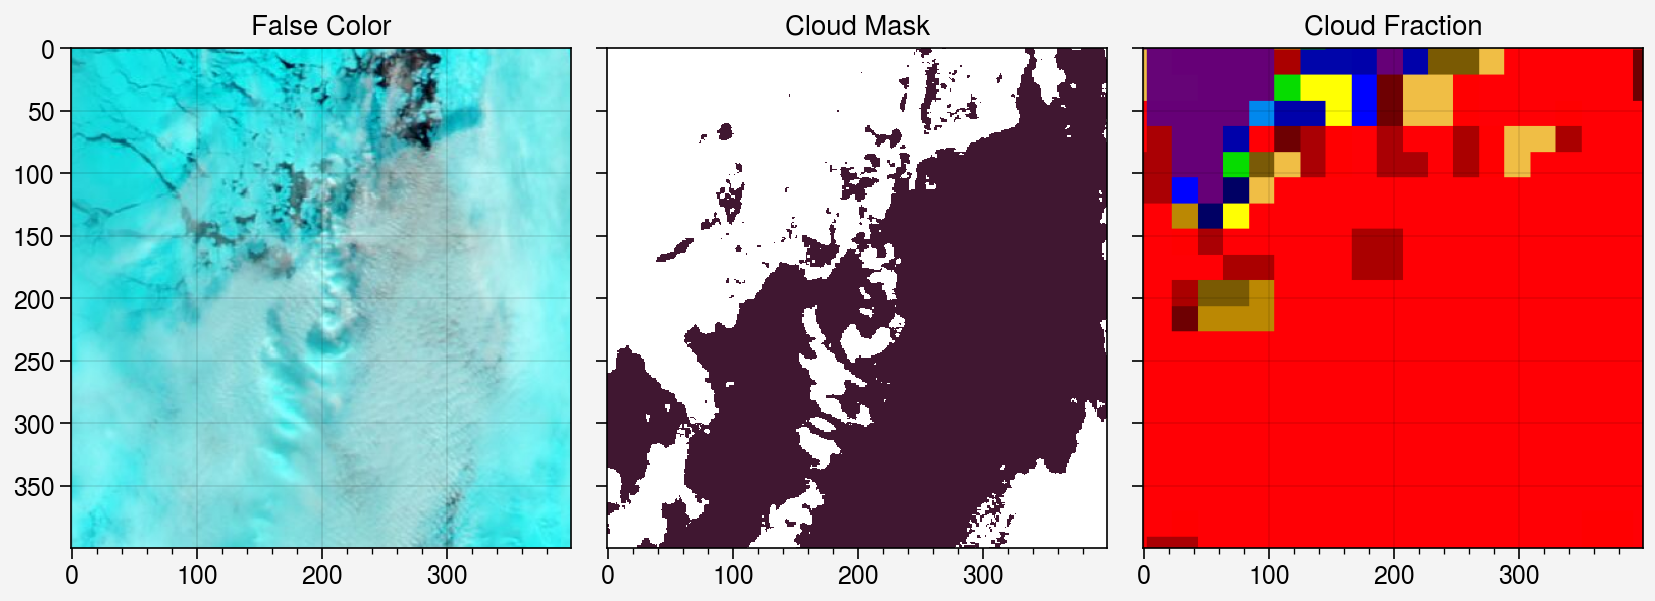

In [25]:
from rasterio.plot import reshape_as_image
fig, ax = pplt.subplots(ncols=3)
case = '021_aqua'
tc = 110
ax[0].imshow(reshape_as_image(fc_images[case]))
ax[2].imshow(reshape_as_image(cl_images[case]))
ax[1].pcolormesh((fc_images[case][0,:,:] > tc).astype(int)) 
ax.format(ytickminor=False)
ax[0].format(title='False Color')
ax[1].format(title='Cloud Mask')
ax[2].format(title='Cloud Fraction')
fig.save('../figures/example_FC_CM_CF_image.png', dpi=300)

Using the MODIS cloud fraction data from the NASA snapshots
- RGB data needs to be translated into cloud fraction

In [27]:
import skimage
key = skimage.io.imread("../data/color_key.png")

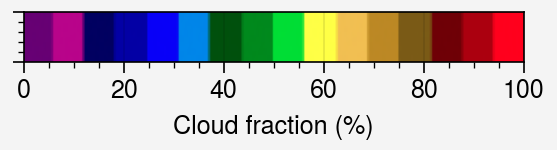

In [28]:
fig, ax = pplt.subplots()
ax.imshow(key, extent=[0, 100, 0, 10])
ax.format(yformatter='none', xlabel='Cloud fraction (%)')

This color bar goes from 0 to 100% cloud cover

In [29]:
vals = pd.DataFrame(np.mean(key[:, :, :-1], axis=0), columns=['r', 'g', 'b']).round(0).astype(int)

In the following figure, we see the column mean RGB intensities for each bin. They follow a clear stepwise pattern, with some noise and transition values. To get the midpoints, we recognize that there are 16 bin centers, and that the first bin starts at approximately the 6th column. We take a rolling mean, then slice in steps of size 14. The centers are shown by the vertical lines below.

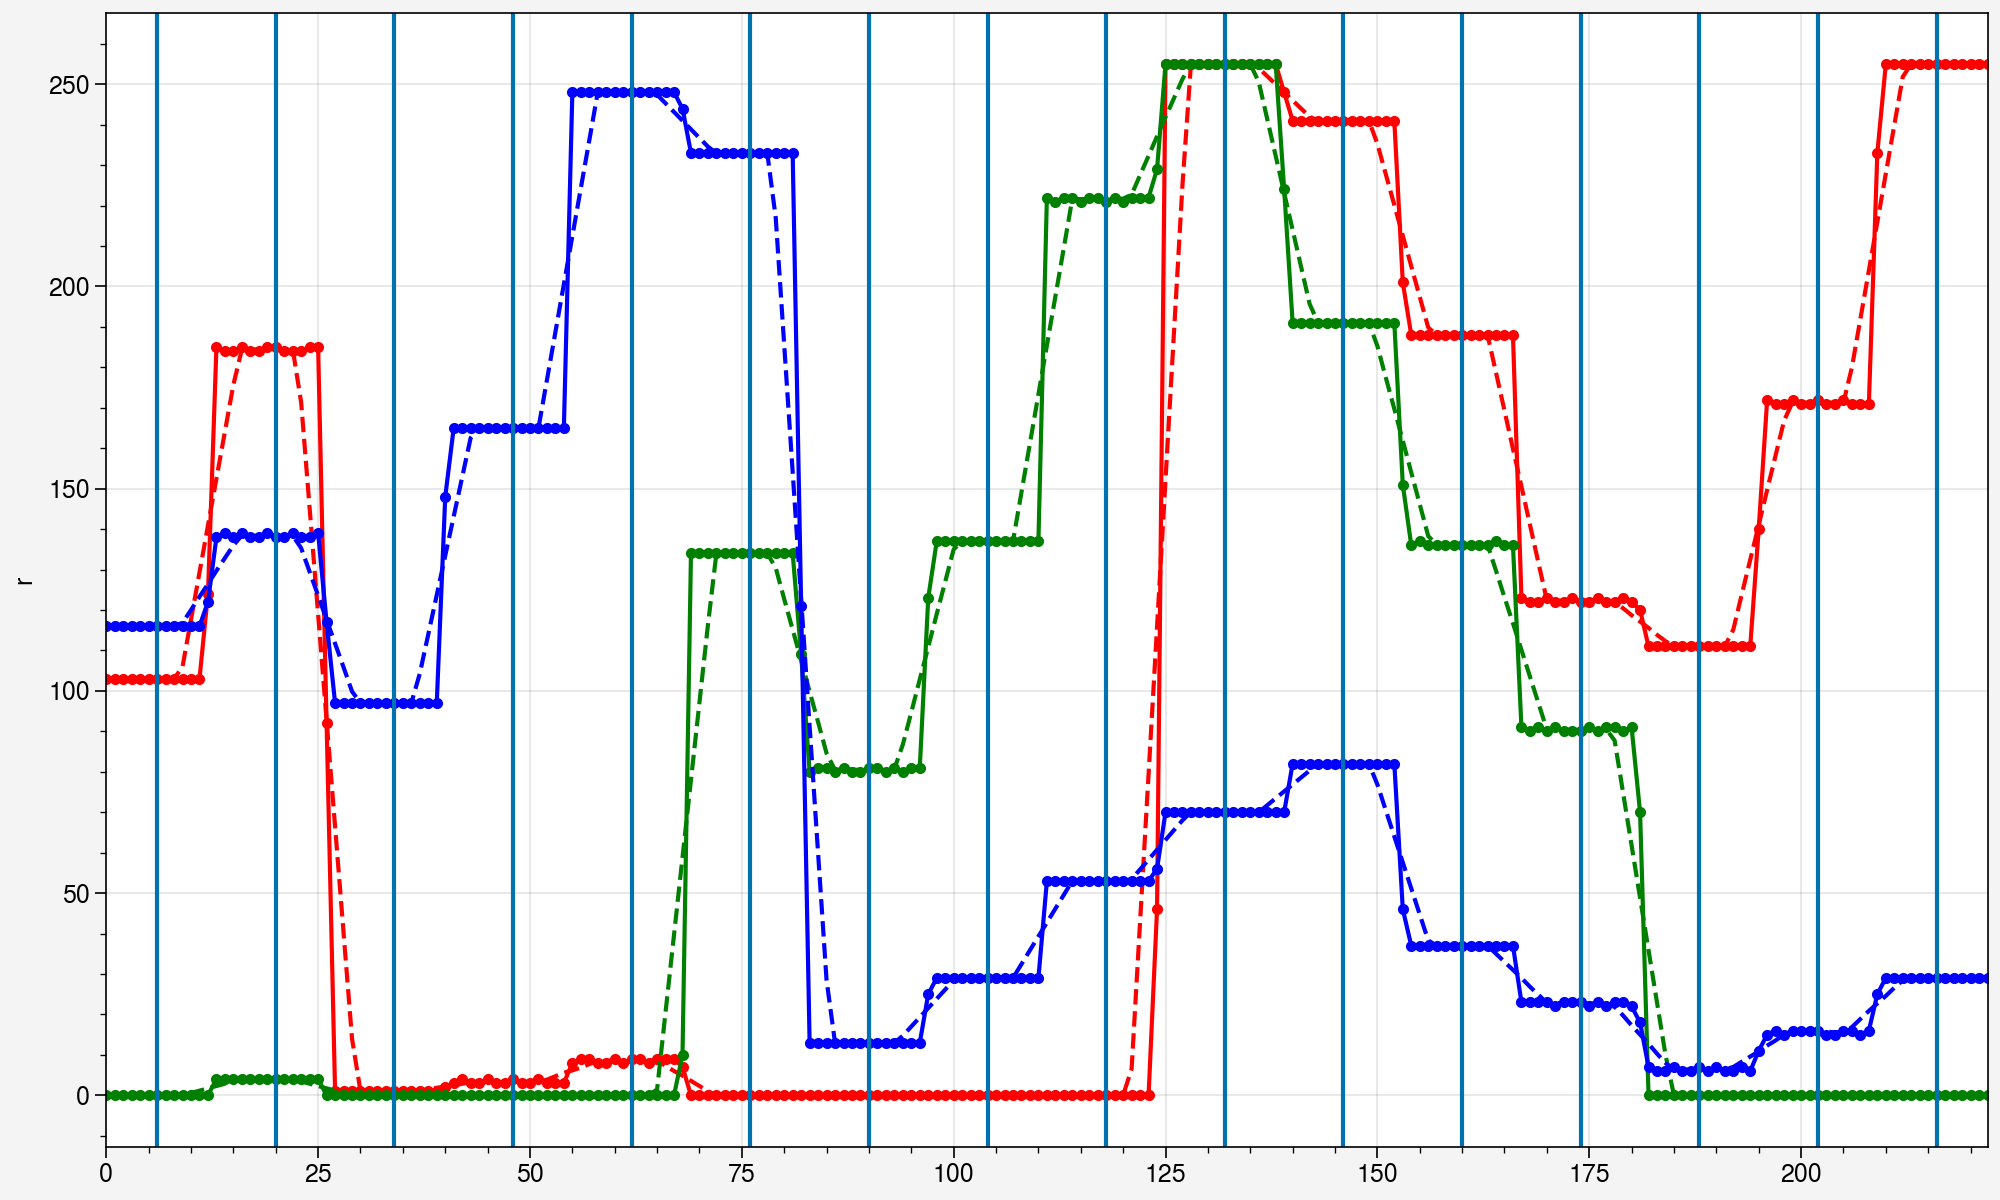

In [30]:
fig, ax = pplt.subplots(width=10, height=6)
vals2 = vals.rolling(7, center=True, min_periods=6).mean()
for c, channel in zip(['r', 'g', 'b'], range(3)):  
    ax.plot(vals[c], marker='.', color=c)
    ax.plot(vals2[c], color=c, ls='--')
for x in np.arange(6, len(vals), 14):
    ax.axvline(x)

In [37]:
bin_mean_values = vals2.iloc[6::14,:].astype(int)[['r', 'g', 'b']]

In [38]:
n = len(bin_mean_values)
print(n)
bin_edges = np.linspace(0, 100, n+1)
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
bin_mean_values.index = bin_centers

16


Our lookup table, with columns for RGB intensities and the cloud fraction they represent as the columns.

In [39]:
bin_mean_values

,r,g,b
3.125,103,0,116
9.375,184,4,138
15.625,1,0,97
21.875,3,0,165
28.125,8,0,248
34.375,0,134,233
40.625,0,80,13
46.875,0,137,29
53.125,0,221,53
59.375,255,255,70


In [166]:
# Loop through images and translate into numerical values

In [31]:
cf_images = {}
cases = [c for c in cl_images]
cases.sort()

In [32]:
# Make the index of the df a unique case label
df.index = [x.case_number + '_' + x.satellite for row, x in df.iterrows()]

In [33]:
%%time
# Only run if needing to do it again -- takes a long time to run!

recompute = False

if recompute:

    for case in cases:
        if case not in cf_images:
            color_im = reshape_as_image(cl_images[case])
            cloudfrac_im = np.zeros((color_im.shape[0], color_im.shape[1]))
            for i in range(cloudfrac_im.shape[0]):
                for j in range(cloudfrac_im.shape[1]):
                    p = color_im[i, j, :-1]
                    cloudfrac_im[i, j] = np.sqrt(np.sum((bin_mean_values - p)**2, axis=1)).idxmin()
            print(case)
            cf_images[case] = cloudfrac_im
            
    for case in cf_images:
        file = fname(df.loc[case]).replace('labeled_floes.png', 'cloudfraction.csv')
        pd.DataFrame(cf_images[case]).to_csv("../data/cloudfraction_numeric/" + file)            

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 16 µs


In [34]:
# Loading from file
cf_images = {}
for case in df.index:
    file = fname(df.loc[case]).replace('labeled_floes.png', 'cloudfraction.csv')
    cf_images[case] = pd.read_csv("../data/cloudfraction_numeric/" + file, index_col=0) 
    cf_images[case].index = cf_images[case].index.astype(int)
    cf_images[case].columns = cf_images[case].columns.astype(int)

In [35]:
df['cloud_fraction_modis'] = np.nan
for case in df.index:
    df.loc[case, 'cloud_fraction_modis'] = np.mean(cf_images[case]/100)

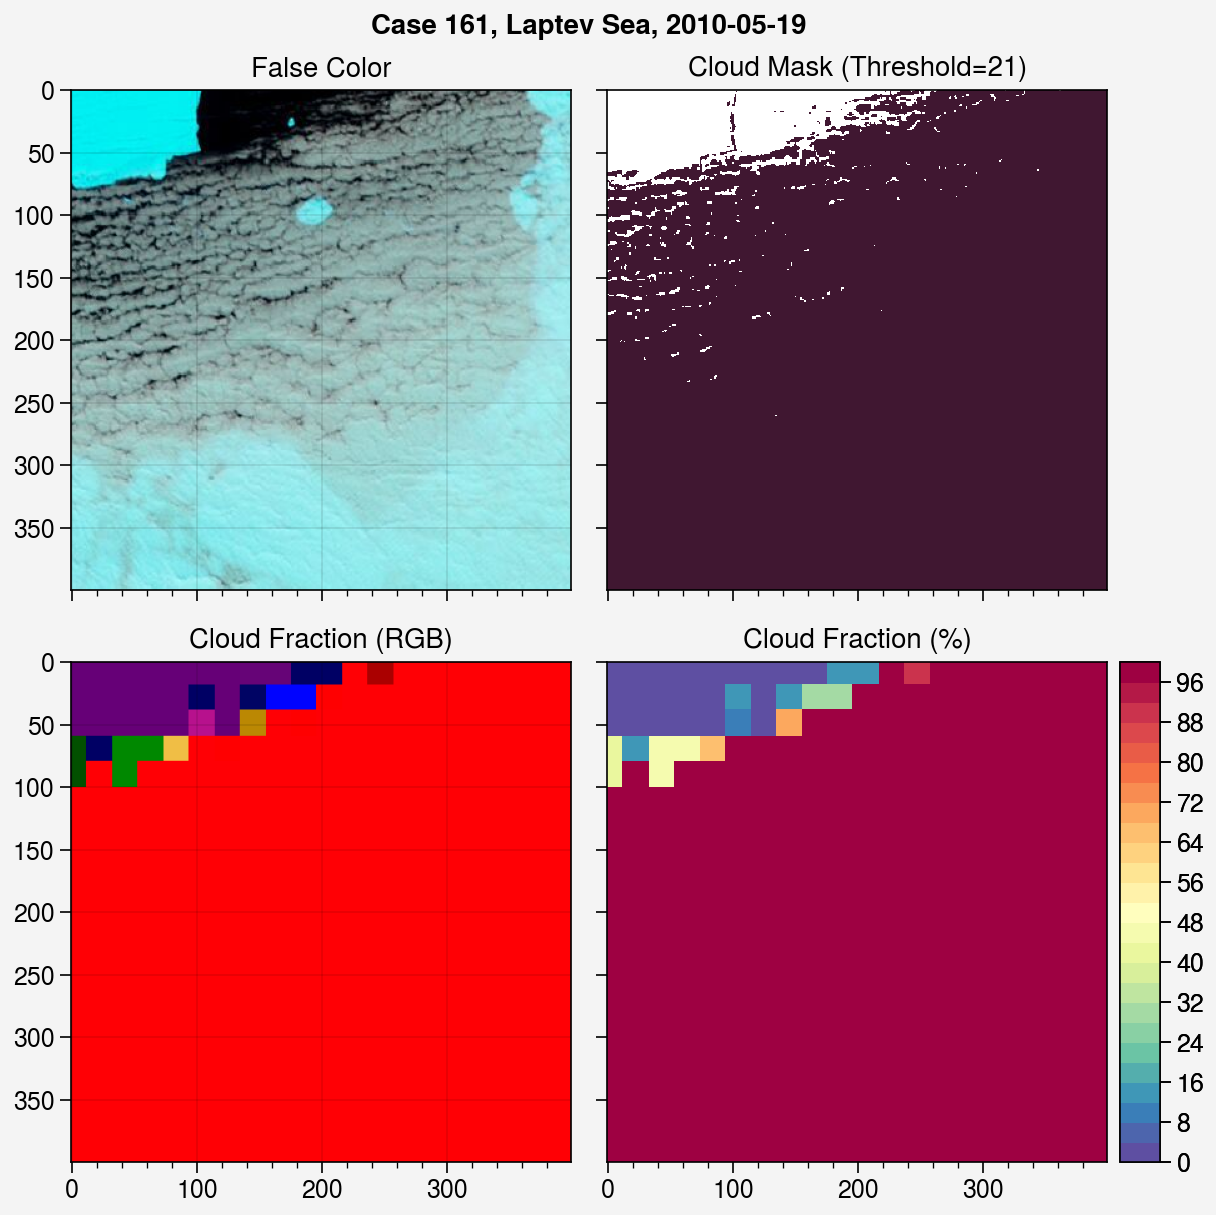

In [45]:
from rasterio.plot import reshape_as_image
fig, ax = pplt.subplots(ncols=2, nrows=2)
case = '161_terra'
tc = 21
ax[0,0].imshow(reshape_as_image(fc_images[case]))
ax[1,0].imshow(reshape_as_image(cl_images[case]))
ax[0,1].pcolormesh((fc_images[case][0,:,:] > tc).astype(int)) 
ax[1,1].pcolormesh(cf_images[case], vmin=0, vmax=100, N=32, cmap='spectral_r', colorbar='r')
ax.format(ytickminor=False)
ax[0,0].format(title='False Color')
ax[0,1].format(title='Cloud Mask (Threshold=' + str(tc) + ')')
ax[1,0].format(title='Cloud Fraction (RGB)')
ax[1,1].format(title='Cloud Fraction (%)')
ax.format(suptitle='Case {c}, {r}, {d}'.format(c=df.loc[case, 'case_number'],
                                               r=df.loc[case, 'region'].replace('_', ' ').title(),
                                               d=df.loc[case, 'start_date'].strftime('%Y-%m-%d')))
fig.save('../figures/example_FC_CM_CF_image_{c}.png'.format(c=case), dpi=300)

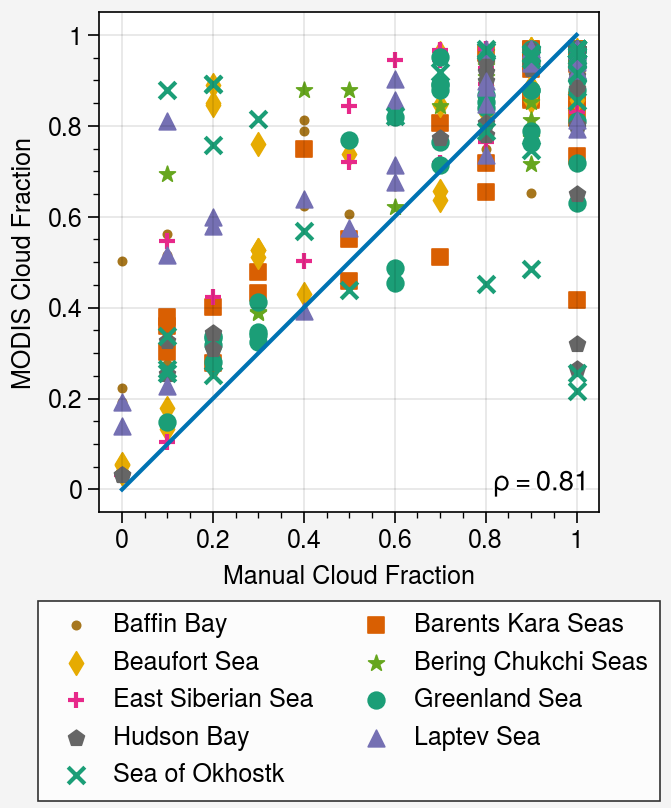

In [47]:
regions = pd.read_csv(dataloc + '/data/metadata/region_definitions.csv', index_col=0)

colors = {region: c['color'] for region, c in zip(
            regions.index,
            pplt.Cycle('dark2', len(regions)))}
markerstyles = {region: ls for region, ls in zip(regions.index,
                        ['o', 's', '^', '+', '*', 'd', '.', 'p', 'x'])}

regions['print_title'] = [c.replace('_', ' ').title().replace('Of', 'of') for c in regions.index]
regions = regions.sort_values('center_lon')


fig, ax = pplt.subplots()
for region, group in df.groupby('region'):
    
    ax.scatter(group['cloud_fraction_manual'], group['cloud_fraction_modis'], label=regions.loc[region, 'print_title'],
               m=markerstyles[region], color=colors[region])
ax.legend(loc='b', ncols=2)
ax.plot([0, 1], [0, 1])
ax.format(ylim=(-0.05, 1.05), xlim=(-0.05, 1.05), xlabel='Manual Cloud Fraction', ylabel='MODIS Cloud Fraction')
ax.format(lrtitle='$\\rho=$' + str(np.round(df['cloud_fraction_modis'].corr(df['cloud_fraction_manual']), 2)))
fig.save('../figures/manual_modis_cloud_comparison.png', dpi=300)

In [68]:
# Outliers
df.loc[np.abs((df.cloud_fraction_modis - df.cloud_fraction_manual)) > 0.5, ['region', 'cloud_fraction_modis', 'cloud_fraction_manual']]

,region,cloud_fraction_modis,cloud_fraction_manual
011_aqua,baffin_bay,0.502147,0.0
013_aqua,baffin_bay,0.853680,0.2
042_terra,barents_kara_seas,0.417928,1.0
056_aqua,beaufort_sea,0.851230,0.2
062_aqua,beaufort_sea,0.846695,0.2
062_terra,beaufort_sea,0.890675,0.2
071_terra,bering_chukchi_seas,0.695057,0.1
133_aqua,hudson_bay,0.264140,1.0
133_terra,hudson_bay,0.320153,1.0
150_terra,laptev_sea,0.810627,0.1


# Finding optimal cloud fraction threshold, now with the MODIS cloud data
This method provides what I think is a reasonable start. However, what it fails to do is to compare _patterns_ of cloud cover. I've computed the cloud fraction for each image, and am looking at the difference in cloud fraction. This is different from computing the error pixel-by-pixel. I would need the cloud mask data rather than the aggregated cloud fraction data for that.

In [48]:
# Compute estimated cloud fraction for a range of threshold values
cloud_cases = df.dropna(subset='cloud_fraction_modis').index
TC = np.linspace(0, 200, 21)
df_est_tc = pd.DataFrame(index=cloud_cases,
                          columns=TC, data=np.nan)
# for each value, compute an estimated cloud fraction based on the fc_images
for tc in df_est_tc.columns:
    for case in df_est_tc.index:
        df_est_tc.loc[case, tc] = np.mean(fc_images[case][0,:,:] > tc)

# finally, calculate the difference between F and F_est
df_err = (df_est_tc.T - df.loc[cloud_cases, 'cloud_fraction_modis']).T

In [49]:
df_training = df_err.sample(frac=2/3, replace=False, random_state=306)
df_testing = df_err.loc[[x for x in df_err.index if x not in df_training.index]]

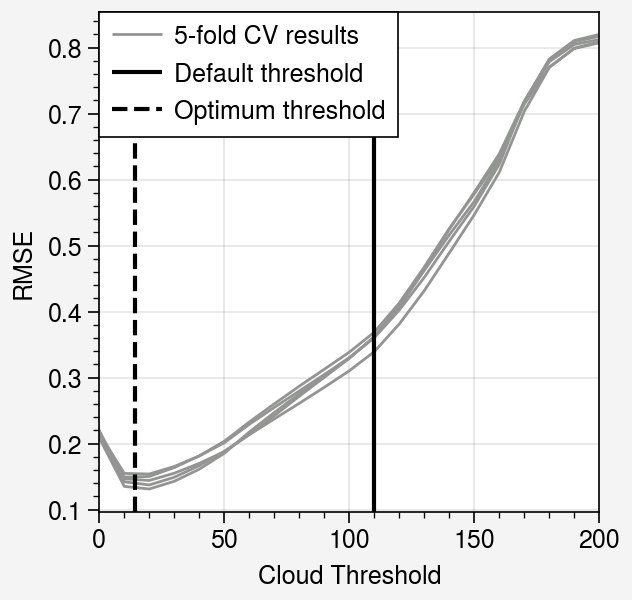

In [51]:
# Test version without splitting by regions to get syntax
fig, ax = pplt.subplots()
x_eval = np.linspace(TC.min(), TC.max(), 201)
results = []

# Initialize cross validation
# TBD: learn how to stratify within the K-fold samplng
kf = KFold(n_splits=5, random_state=20240126, shuffle=True)

for i, (train_index, test_index) in enumerate(kf.split(df_training)):
    # first get the root mean square error as a function of TC
    rmse = np.sqrt(np.mean( df_training.iloc[train_index,:]**2, axis=0))
    
    # then find the minimum
    tc_optimal = pd.Series(interp1d(x=rmse.index, y=rmse.values, kind='quadratic')(x_eval), index=x_eval).idxmin()

    test_cases = df_training.iloc[test_index, :].index
    test_results = np.array([
        np.mean(fc_images[case][0,:,:] > tc_optimal) - df.loc[case, 'cloud_fraction_modis']
            for case in test_cases])
    tc_rmse = np.sqrt(np.mean(test_results**2))
    results.append([tc_optimal, tc_rmse])
    
    ax.plot(rmse, label='', color='gray', lw=1) #label='k=' + str(i))
ax.plot([],[], color='gray', lw=1, label='5-fold CV results')
kfold_results = pd.DataFrame(results, columns=['TC', 'RMSE']).mean(axis=0).round(2)

ax.axvline(110, color='k', label='Default threshold')
ax.axvline(kfold_results['TC'], color='k', ls='--', label='Optimum threshold')
ax.format(ylabel='RMSE', xlabel='Cloud Threshold')
ax.legend(loc='ul', ncols=1, alpha=1)

# fig.save('../figures/cloud_fraction_calibration_modis.png', dpi=300)

In [52]:
kfold_results = pd.DataFrame(results, columns=['TC', 'RMSE'])
kfold_results

,TC,RMSE
0,14.0,0.092820
1,15.0,0.161625
2,14.0,0.138932
3,14.0,0.182061
4,14.0,0.119853


In [53]:
kfold_results.mean(axis=0).round(2)

TC      14.20
RMSE     0.14
dtype: float64

In [54]:
# Error against the held-out data
tc = 14
test_results = np.array([
    np.mean(fc_images[case][0,:,:] > tc) - df.loc[case, 'cloud_fraction_modis']
        for case in df_testing.index])
test_results = pd.Series(test_results, index=df_testing.index)
tc_rmse = np.sqrt(np.mean(test_results**2))
print('CF error:', np.round(tc_rmse, 3))

CF error: 0.126


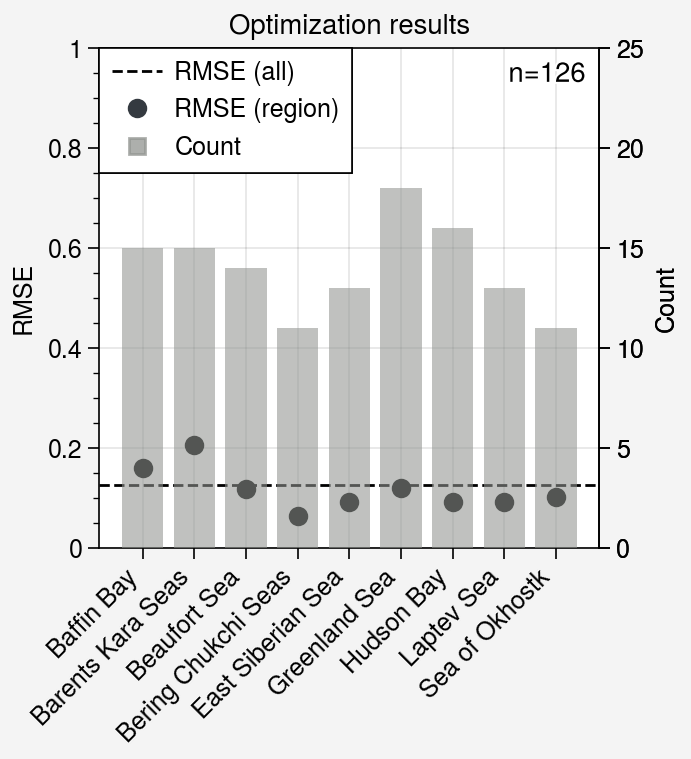

In [56]:
fig, ax = pplt.subplots()
ax.plot(
    test_results.groupby(df.loc[test_results.index, 'region']).apply(lambda x: np.sqrt(np.mean(x**2))),
    marker='o', lw=0, zorder=2, color='k')
ax.axhline(tc_rmse, color='k', ls='--', lw=1)
ax2 = ax.twinx()
plot_data = test_results.groupby(df.loc[test_results.index, 'region']).count()
plot_data.index = [x.replace('_', ' ').title().replace('Of', 'of') for x in plot_data.index]

ax2.bar(
    plot_data, zorder=0, color='gray', alpha=0.35
    )
ax2.format(ylabel='Count', ytickminor=False)

ax.format(xrotation=45, ylim=(0, 1), xlabel='', ylabel='RMSE', title='Optimization results')
ax.format(urtitle='n=' + str(len(test_results)))
ax2.format(ylim=(0, 25))
h = [ax.plot([],[],marker='', ls='--', color='k', lw=1),
     ax.plot([],[],marker='o', color='gray8', lw=0),
     ax.plot([],[],marker='s', color='gray', alpha=0.75, lw=0)]
ax2.legend(h, ['RMSE (all)', 'RMSE (region)', 'Count'], loc='ul', ncols=1, alpha=1)
# fig.save('../figures/cloud_fraction_validation_modis.png', dpi=300)

# Pixel unmasking: identifying optically thin clouds
The original algorithm is
1. Mask all pixels with $l_1 > 110 = T_C$.
2. Unmask pixels with $l_1 < 200 = T_1$ and $l_2 > 190 = T_2$.
3. Unmask pixels with $l_1/l_2 < 0.75 = R_{1,2}$.

In the prior sections, we have found that the first step underestimates the total cloud cover (noting, however, that this high threshold was set just to mask the clouds with the highest opacity). To identify the thin clouds, we have three parameters to adjust, making the optimization a bit more challenging. 



Parameters to optimize over
1. $T_1$. Operates on channel 1.
2. $T_2$. Operates on channel 2.
3. $R_{1,2}$. Ratio of $T_1$ and $T_2$. Pixels with $R_{1,2}$ less than the threshold are unmasked.
Point of clarification for the cloud mask: 1 and 2 are an intersection, so they can really only be varied together.  For the ratio, is this additional unmasking or a conditional on the prior conditions?

The `mask_cloud_ice` variable 

In [57]:
case = '152_aqua'

T1 = 160
T2 = 200
R_lower = 0
R_upper = 0.6
tc = 27

clouds_view = fc_images[case][0,:,:] > tc # true == cloudy pixel
mask_b7b2 = (fc_images[case][0,:,:] < T1) & (fc_images[case][1,:,:] > T2) # true == thin cloud
mask_ratio = fc_images[case][0,:,:]/fc_images[case][1,:,:]
mask_cloud_ice = (mask_ratio > R_lower) & (mask_ratio < R_upper)
mask_cloud_ice = mask_cloud_ice & mask_b7b2
cloud_mask = ~(mask_cloud_ice | ~clouds_view)

/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_72570/80420904.py:11: RuntimeWarning: divide by zero encountered in divide
  mask_ratio = fc_images[case][0,:,:]/fc_images[case][1,:,:]
/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_72570/80420904.py:11: RuntimeWarning: invalid value encountered in divide
  mask_ratio = fc_images[case][0,:,:]/fc_images[case][1,:,:]


In [58]:
def generate_masks(fc_image, t1, t2, r_lower, r_upper, tc):
    """Generate the all-cloud and opaque-cloud masks. Opaque cloud mask is defined as a subset
    of the all-cloud mask where the ice floes are visible."""
    clouds_view = fc_image[0,:,:] > tc # true == cloudy pixel
    mask_b7b2 = (fc_image[0,:,:] < t1) & (fc_image[1,:,:] > t2) # true == thin cloud
    mask_ratio = fc_image[0,:,:]/fc_image[1,:,:]
    mask_cloud_ice = (mask_ratio > r_lower) & (mask_ratio < r_upper)
    mask_cloud_ice = mask_cloud_ice & mask_b7b2
    cloud_mask = ~(mask_cloud_ice | ~clouds_view)
    return clouds_view, cloud_mask

In [59]:
def cloud_fraction_loss_function(new_mask, old_mask, sea_ice_labels):
    """Relative change in cloud fraction against the old mask.
    If no clouds, then return 0. New mask should be 1 where there are clouds."""

    cf_new = np.mean(new_mask)
    cf_old = np.mean(old_mask)
    if cf_old > 1e-4:
        return (cf_old - cf_new)/cf_old
    else:
        return 0

def sea_ice_fraction_loss_function(new_mask, sea_ice_labels):
    """Relative decrease in sea ice cover from ground truth (sea_ice_labels) to the new_mask.
    If no sea ice, return 0"""

    sea_ice = np.sum(sea_ice_labels > 0)
    if sea_ice == 0:
        return 0

    uncovered_ice = np.sum((sea_ice_labels > 0) & ~new_mask)
    return (sea_ice - uncovered_ice)/sea_ice


In [40]:
df.loc[(df.visible_sea_ice == 'no') & (df.cloud_fraction_modis > 0.8)]

,case_number,region,start_date,center_lon,center_lat,center_x,center_y,month,sea_ice_fraction,mean_sea_ice_concentration,...,cloud_fraction_manual,cloud_category_manual,artifacts,qa_analyst,qa_reviewer,fl_analyst,fl_reviewer,psd_file,notes,cloud_fraction_modis
028_aqua,028,barents_kara_seas,2018-08-19,44.060809,82.968683,762500,-12500,8,0.520,0.734,...,1.0,opaque,yes,daniel,NaN,NaN,NaN,NaN,NaN,0.966423
028_terra,028,barents_kara_seas,2018-08-19,44.060809,82.968683,762500,-12500,8,0.520,0.734,...,1.0,opaque,no,daniel,NaN,NaN,NaN,NaN,NaN,0.852209
036_terra,036,barents_kara_seas,2020-07-01,63.838434,79.663619,1062500,362500,7,0.960,0.848,...,1.0,opaque,no,daniel,ethan,emma,daniel,NaN,NaN,0.965312
041_aqua,041,barents_kara_seas,2015-06-18,78.584160,72.810848,1562500,1037500,6,1.000,0.733,...,1.0,scattered,no,daniel,NaN,NaN,NaN,NaN,NaN,0.968750
041_terra,041,barents_kara_seas,2015-06-18,78.584160,72.810848,1562500,1037500,6,1.000,0.733,...,1.0,scattered,yes,daniel,NaN,NaN,NaN,NaN,NaN,0.961061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174_terra,174,sea_of_okhostk,2022-05-24,140.550500,54.183539,-387500,3987500,5,0.762,0.522,...,1.0,opaque,yes,emma,ellen,NaN,NaN,NaN,NaN,0.968750
177_aqua,177,sea_of_okhostk,2016-03-31,144.616592,55.785542,-637500,3762500,3,1.000,0.725,...,1.0,opaque,no,emma,ellen,NaN,NaN,NaN,NaN,0.968750
177_terra,177,sea_of_okhostk,2016-03-31,144.616592,55.785542,-637500,3762500,3,1.000,0.725,...,1.0,opaque,yes,emma,ellen,NaN,NaN,NaN,NaN,0.968750
185_aqua,185,sea_of_okhostk,2011-05-04,154.474214,58.589917,-1162500,3287500,5,0.625,0.383,...,1.0,opaque,no,daniel,minki,NaN,NaN,NaN,NaN,0.968750


In [60]:
lb_images.keys()

dict_keys(['001_aqua', '001_terra', '004_aqua', '004_terra', '005_aqua', '005_terra', '006_aqua', '006_terra', '008_aqua', '008_terra', '009_aqua', '009_terra', '010_aqua', '010_terra', '012_aqua', '012_terra', '015_aqua', '015_terra', '016_aqua', '016_terra', '019_aqua', '019_terra', '021_aqua', '021_terra', '029_aqua', '029_terra', '033_aqua', '033_terra', '036_aqua', '046_aqua', '046_terra', '048_aqua', '048_terra', '051_aqua', '051_terra', '056_aqua', '056_terra', '062_aqua', '062_terra', '068_aqua', '068_terra', '071_aqua', '071_terra', '075_aqua', '075_terra', '081_aqua', '081_terra', '093_aqua', '093_terra', '100_aqua', '100_terra', '103_aqua', '108_aqua', '108_terra', '109_aqua', '109_terra', '110_aqua', '110_terra', '115_aqua', '115_terra', '116_aqua', '116_terra', '118_aqua', '118_terra', '119_aqua', '119_terra', '121_aqua', '121_terra', '138_aqua', '138_terra', '141_aqua', '141_terra', '144_aqua', '144_terra', '150_aqua', '150_terra', '152_aqua', '152_terra', '156_aqua', '15

/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_72570/3762505851.py:10: RuntimeWarning: divide by zero encountered in divide
  mask_ratio = fc_images[case][0,:,:]/fc_images[case][1,:,:]
/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_72570/3762505851.py:10: RuntimeWarning: invalid value encountered in divide
  mask_ratio = fc_images[case][0,:,:]/fc_images[case][1,:,:]
/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_72570/1523296688.py:6: RuntimeWarning: divide by zero encountered in divide
  mask_ratio = fc_image[0,:,:]/fc_image[1,:,:]
/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_72570/1523296688.py:6: RuntimeWarning: invalid value encountered in divide
  mask_ratio = fc_image[0,:,:]/fc_image[1,:,:]
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


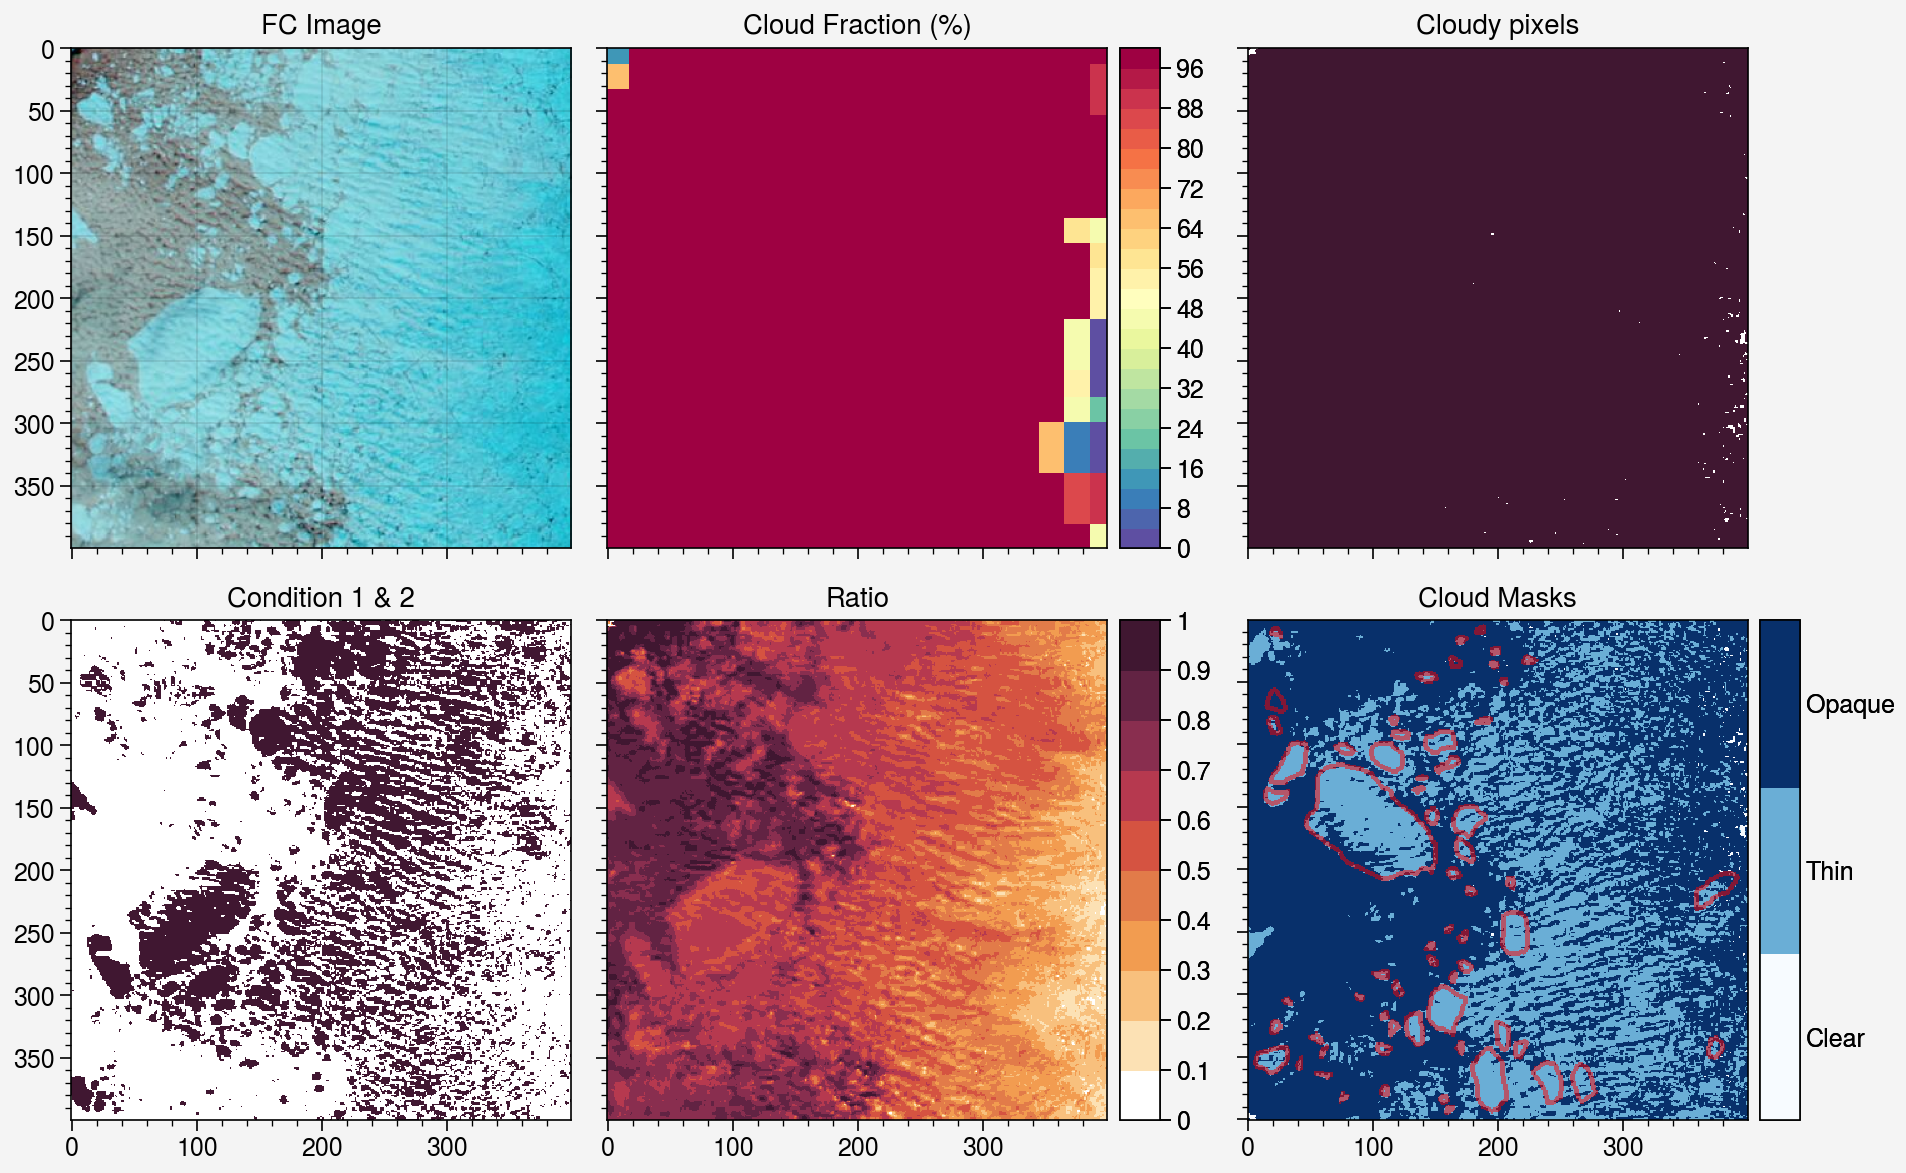

In [77]:
case = '019_aqua'
T1 = 190
T2 = 200
R_lower = 0
R_upper = 0.75
tc = 14

# clouds_view = fc_images[case][0,:,:] > tc # true == cloudy pixel
mask_b7b2 = (fc_images[case][0,:,:] < T1) & (fc_images[case][1,:,:] > T2) # true == thin cloud
mask_ratio = fc_images[case][0,:,:]/fc_images[case][1,:,:]
mask_cloud_ice = (mask_ratio > R_lower) & (mask_ratio < R_upper)
mask_cloud_ice = mask_cloud_ice & mask_b7b2
# cloud_mask = ~(mask_cloud_ice | ~clouds_view)
clouds_view, cloud_mask = generate_masks(fc_images[case], t1=T1, t2=T2, r_lower=0, r_upper=R_upper, tc=tc)

fig, axs = pplt.subplots(ncols=3, nrows=2)
layered_mask = ((cloud_mask).astype(float) + clouds_view.astype(float))/2
for ax, data, title in zip(axs, [fc_images[case], cf_images[case], clouds_view, mask_b7b2, mask_ratio, layered_mask],
                          ['FC Image', 'Cloud Fraction (%)', 'Cloudy pixels', 'Condition 1 & 2', 'Ratio', 'Cloud Masks']):
    if title == 'FC Image':
        ax.imshow(reshape_as_image(data))
    elif title == 'Cloud Fraction (%)':
        ax.pcolormesh(data.values, vmin=0, vmax=100, N=32, cmap='spectral_r', colorbar='r')
    else:
        c = ax.pcolormesh(data, vmin=0, vmax=1)
        if title=='Ratio':
            ax.colorbar(c, loc='r')
        if title=='Cloud Masks':
            c = ax.pcolormesh(data, N=3, cmap='blues')
            ax.colorbar(c, ticks=[.2, 0.6, 1], ticklabels=['Clear', 'Thin', 'Opaque'], ticklen=0.1)

    ax.format(title=title, yreverse=True)
manual_floe_labels = lb_images[case][0,:,:] % 2

outlines = manual_floe_labels - skimage.morphology.erosion(manual_floe_labels, skimage.morphology.disk(4))
axs[1, 2].pcolormesh(np.ma.masked_array(outlines, outlines==0), color='r', alpha=0.5)


axs[1,0].format(yreverse=True)
axs[1,1].format(yreverse=True)

The calibration in this section aims to minimize the reduction in the cloud mask while maximizing the fraction of manually-labeled ice floes that are uncovered. A big challenge here is that the images vary quite a bit in the number of ice floes. It is not obvious how we should weight the results, whether by pixels or what.

In [74]:
(lb_images[case][0,:,:] % 2).max()

1

/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/opt/miniconda3/envs/cal-val/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


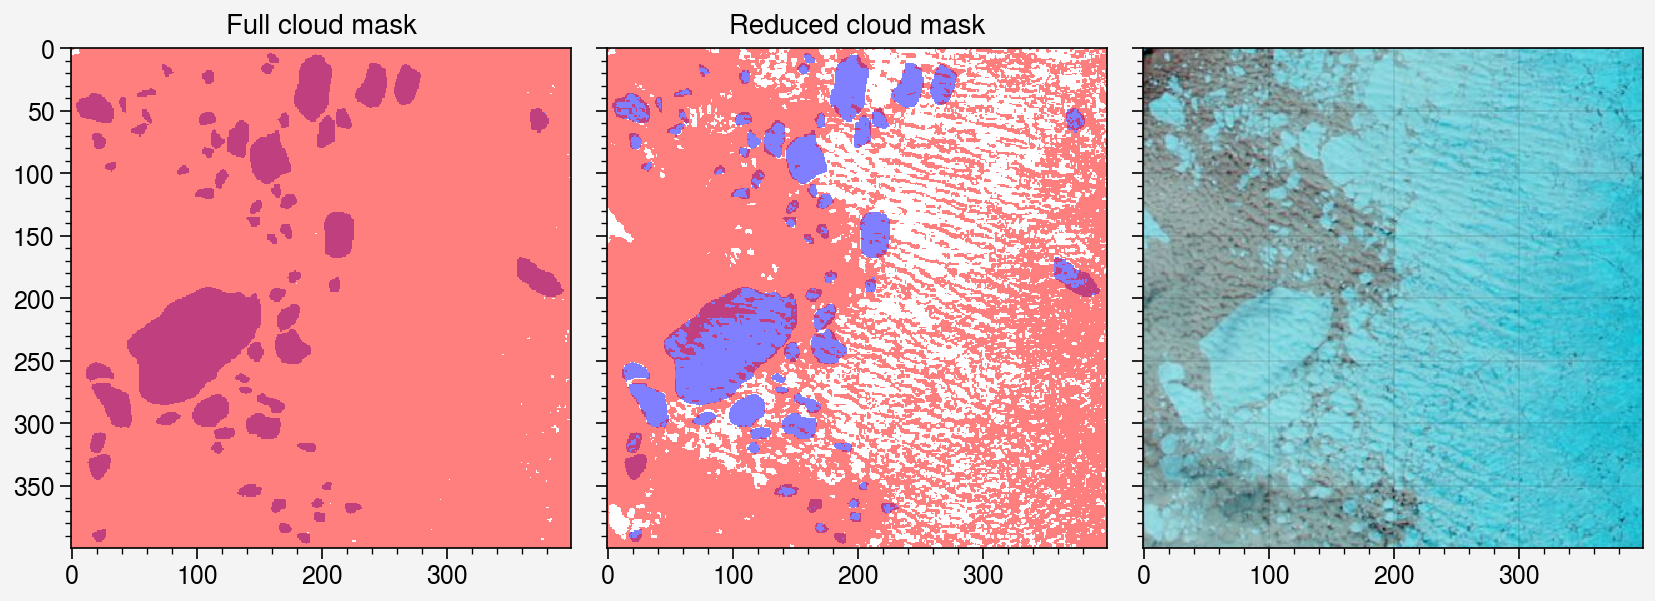

In [397]:
fig, ax = pplt.subplots(ncols=3)
manual_floe_labels = np.ma.masked_array(lb_images[case][0,:,:], mask=lb_images[case][0,:,:]==0)
ax[0].pcolormesh(manual_floe_labels, color='b', alpha=0.5)
ax[0].pcolormesh(np.ma.masked_array(clouds_view, clouds_view==0), color='r', alpha=0.5)
ax[0].format(title='Full cloud mask')

ax[1].pcolormesh(manual_floe_labels, color='b', alpha=0.5)
ax[1].pcolormesh(np.ma.masked_array(cloud_mask, cloud_mask==0), color='r', alpha=0.5)
ax[1].format(title='Reduced cloud mask')

ax[2].imshow(reshape_as_image(fc_images[case]))

ax.format(yreverse=True)

# Alternative approach
We can look for the range of brightnesses that are observed for ice floes that are under clouds.  The thresholds should be grounded in reality in a sense at least. We can do a sweep and average across many cases, but would it be as effective? 

* We don't want a threshold so high that raising it simply increases the error in cloud cover.
* Similarly for too low.
* In between, we may want to optimize.

fc1 clear 34.0
fc1 cloudy 139.0
fc2 clear 215.0
fc2 cloudy 127.0


/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_65967/2580254816.py:49: RuntimeWarning: divide by zero encountered in divide
  brightness = np.ravel(fc_images[case][0,:,:]) / np.ravel(fc_images[case][1,:,:])
/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_65967/2580254816.py:49: RuntimeWarning: invalid value encountered in divide
  brightness = np.ravel(fc_images[case][0,:,:]) / np.ravel(fc_images[case][1,:,:])


fc1/fc2 clear 0.3815789473684211
fc1/fc2 cloudy 0.6753246753246753


(array([  48902.,   11059.,   15858.,   31075.,   78344.,  188852.,
         270930.,  285995.,  279823.,  287551.,  284044.,  286847.,
         301603.,  388187.,  516206.,  514212.,  499668.,  541015.,
         587952.,  630389.,  737436.,  960172., 1278589.,  974813.,
         761492.,  418615.,  187290.,  110296.,   81599.]),
 array([0.        , 0.03448276, 0.06896552, 0.10344828, 0.13793103,
        0.17241379, 0.20689655, 0.24137931, 0.27586207, 0.31034483,
        0.34482759, 0.37931034, 0.4137931 , 0.44827586, 0.48275862,
        0.51724138, 0.55172414, 0.5862069 , 0.62068966, 0.65517241,
        0.68965517, 0.72413793, 0.75862069, 0.79310345, 0.82758621,
        0.86206897, 0.89655172, 0.93103448, 0.96551724, 1.        ]),
 <BarContainer object of 29 artists>)

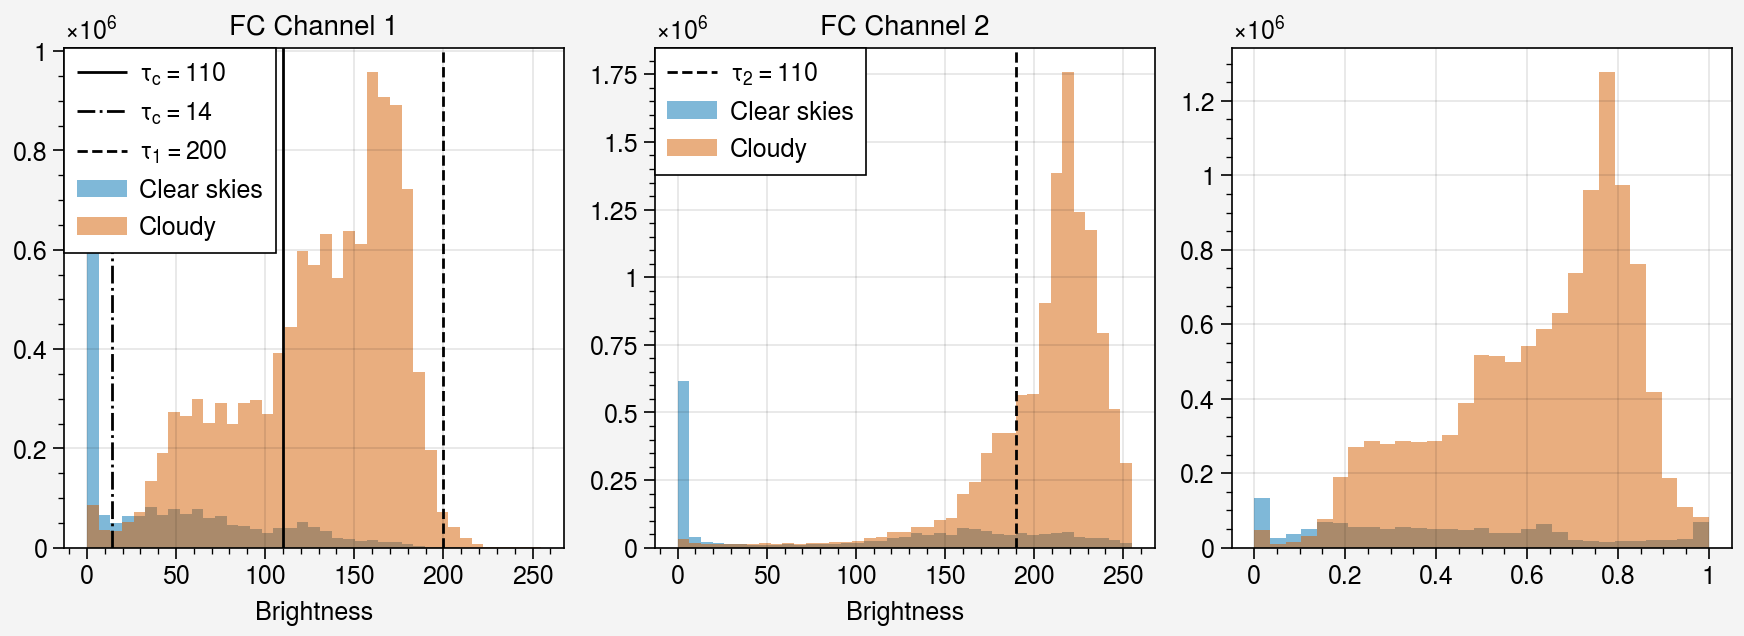

In [380]:
nearly_full_cloud_cover = df.loc[df.visible_sea_ice=='no'].index

fig, ax = pplt.subplots(ncols=3, sharex=False, sharey=False)
all_cloudy = []
all_clear = []
for case in nearly_full_cloud_cover:
    if fc_images[case].shape[1] == 400:
        brightness = np.ravel(fc_images[case][0,:,:])
        cloudy = np.ravel(cf_images[case]) > 80
        clear = np.ravel(cf_images[case]) <= 80
        all_cloudy.append(brightness[cloudy])
        all_clear.append(brightness[clear])
all_clear = np.hstack(all_clear)
all_cloudy = np.hstack(all_cloudy)
print('fc1', 'clear', np.median(all_clear))
print('fc1', 'cloudy', np.median(all_cloudy))
ax[0].hist(all_clear, alpha=0.5, label='Clear skies', bins=np.linspace(0, 255, 40))
ax[0].hist(all_cloudy, alpha=0.5, label='Cloudy', bins=np.linspace(0, 255, 40))
ax[0].axvline(110, label='$\\tau_c = 110$', color='k', ls='-', lw=1)
ax[0].axvline(14, label='$\\tau_c = 14$', color='k', ls='-.', lw=1)
ax[0].axvline(200, label='$\\tau_1 = 200$', color='k', ls='--', lw=1)
ax[0].format(title='FC Channel 1', xlabel='Brightness')
ax[0].legend(ncols=1, alpha=1)

all_cloudy = []
all_clear = []
for case in nearly_full_cloud_cover:
    if fc_images[case].shape[1] == 400:
        brightness = np.ravel(fc_images[case][1,:,:])
        cloudy = np.ravel(cf_images[case]) > 80
        clear = np.ravel(cf_images[case]) <= 80
        all_cloudy.append(brightness[cloudy])
        all_clear.append(brightness[clear])
all_cloudy = np.hstack(all_cloudy)
all_clear = np.hstack(all_clear)
print('fc2', 'clear', np.median(all_cloudy))
print('fc2', 'cloudy', np.median(all_clear))

ax[1].hist(all_clear, alpha=0.5, label='Clear skies', bins=np.linspace(0, 255, 40))
ax[1].hist(all_cloudy, alpha=0.5, label='Cloudy', bins=np.linspace(0, 255, 40))
ax[1].axvline(190, label='$\\tau_2 = 110$', color='k', ls='--', lw=1)
ax[1].format(title='FC Channel 2', xlabel='Brightness')
ax[1].legend(ncols=1, alpha=1)

all_cloudy = []
all_clear = []
for case in nearly_full_cloud_cover:
    if fc_images[case].shape[1] == 400:
        brightness = np.ravel(fc_images[case][0,:,:]) / np.ravel(fc_images[case][1,:,:])
        cloudy = np.ravel(cf_images[case]) > 80
        clear = np.ravel(cf_images[case]) <= 80
        all_cloudy.append(brightness[cloudy])
        all_clear.append(brightness[clear])

r = np.hstack(all_clear)
r = r[(r >= 0) & (r <= 1)]
print('fc1/fc2', 'clear', np.median(r))
ax[2].hist(r, alpha=0.5, label='Clear skies', bins=np.linspace(0, 1, 30))

r = np.hstack(all_cloudy)
r = r[(r >= 0) & (r <= 1)]
print('fc1/fc2', 'cloudy', np.median(r))
ax[2].hist(r, alpha=0.5, label='Clear skies', bins=np.linspace(0, 1, 30))


fc1 clear 16.0
fc1 cloudy 138.0
fc2 clear 233.0
fc2 cloudy 225.0


/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_65967/312115125.py:47: RuntimeWarning: divide by zero encountered in divide
  brightness = np.ravel(fc_images[case][0,:,:]) / np.ravel(fc_images[case][1,:,:])
/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_65967/312115125.py:47: RuntimeWarning: invalid value encountered in divide
  brightness = np.ravel(fc_images[case][0,:,:]) / np.ravel(fc_images[case][1,:,:])


fc1/fc2 clear 0.07058823529411765
fc1/fc2 cloudy 0.634703196347032


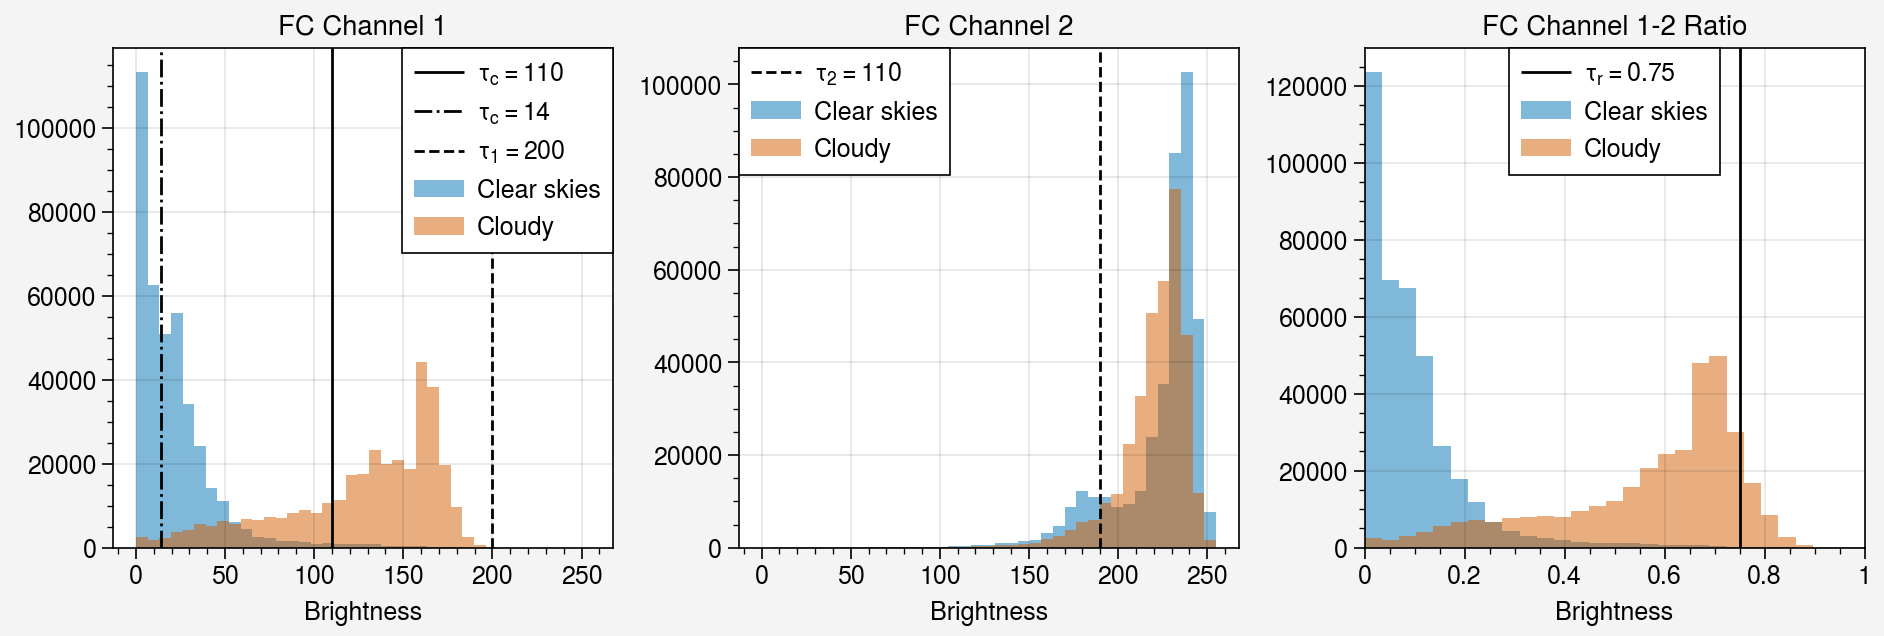

In [262]:
fig, ax = pplt.subplots(ncols=3, sharex=False, sharey=False)
sea_ice_cloudy = []
sea_ice_clear = []
for case in lb_images:
    if lb_images[case].shape[1] == 400:
        brightness = np.ravel(fc_images[case][0,:,:])
        cloudy = np.ravel(cf_images[case]) > 80
        sea_ice = np.ravel(lb_images[case][0,:,:]) > 0
        sea_ice_cloudy.append(brightness[cloudy & sea_ice])
        sea_ice_clear.append(brightness[~cloudy & sea_ice])
sea_ice_clear = np.hstack(sea_ice_clear)
sea_ice_cloudy = np.hstack(sea_ice_cloudy)
print('fc1', 'clear', np.median(sea_ice_clear))
print('fc1', 'cloudy', np.median(sea_ice_cloudy))
ax[0].hist(np.hstack(sea_ice_clear), alpha=0.5, label='Clear skies', bins=np.linspace(0, 255, 40))
ax[0].hist(np.hstack(sea_ice_cloudy), alpha=0.5, label='Cloudy', bins=np.linspace(0, 255, 40))
ax[0].axvline(110, label='$\\tau_c = 110$', color='k', ls='-', lw=1)
ax[0].axvline(14, label='$\\tau_c = 14$', color='k', ls='-.', lw=1)
ax[0].axvline(200, label='$\\tau_1 = 200$', color='k', ls='--', lw=1)
ax[0].format(title='FC Channel 1', xlabel='Brightness')
ax[0].legend(ncols=1, alpha=1)

sea_ice_cloudy = []
sea_ice_clear = []
for case in lb_images:
    if lb_images[case].shape[1] == 400:
        brightness = np.ravel(fc_images[case][1,:,:])
        cloudy = np.ravel(cf_images[case]) > 80
        sea_ice = np.ravel(lb_images[case][0,:,:]) > 0
        sea_ice_cloudy.append(brightness[cloudy & sea_ice])
        sea_ice_clear.append(brightness[~cloudy & sea_ice])
sea_ice_clear = np.hstack(sea_ice_clear)
sea_ice_cloudy = np.hstack(sea_ice_cloudy)
print('fc2', 'clear', np.median(sea_ice_clear))
print('fc2', 'cloudy', np.median(sea_ice_cloudy))

ax[1].hist(np.hstack(sea_ice_clear), alpha=0.5, label='Clear skies', bins=np.linspace(0, 255, 40))
ax[1].hist(np.hstack(sea_ice_cloudy), alpha=0.5, label='Cloudy', bins=np.linspace(0, 255, 40))
ax[1].axvline(190, label='$\\tau_2 = 110$', color='k', ls='--', lw=1)
ax[1].format(title='FC Channel 2', xlabel='Brightness')
ax[1].legend(ncols=1, alpha=1)

sea_ice_cloudy = []
sea_ice_clear = []
for case in lb_images:
    if lb_images[case].shape[1] == 400:
        brightness = np.ravel(fc_images[case][0,:,:]) / np.ravel(fc_images[case][1,:,:])
        cloudy = np.ravel(cf_images[case]) > 80
        sea_ice = np.ravel(lb_images[case][0,:,:]) > 0
        sea_ice_cloudy.append(brightness[cloudy & sea_ice])
        sea_ice_clear.append(brightness[~cloudy & sea_ice])

r = np.hstack(sea_ice_clear)
r = r[(r >= 0) & (r <= 1)]
print('fc1/fc2', 'clear', np.median(r))
ax[2].hist(r, alpha=0.5, label='Clear skies', bins=np.linspace(0, 1, 30))

r = np.hstack(sea_ice_cloudy)
r = r[(r >= 0) & (r <= 1)]
print('fc1/fc2', 'cloudy', np.median(r))

ax[2].hist(r, alpha=0.5, label='Cloudy', bins=np.linspace(0, 1, 30))
ax[2].axvline(0.75, label='$\\tau_r = 0.75$', color='k', ls='-', lw=1)
ax[2].format(title='FC Channel 1-2 Ratio', xlabel='Brightness', xlim=(0, 1))
ax[2].legend(ncols=1, alpha=1)
fig.save('../figures/false_color_histograms.png', dpi=300)


We divided the ground truth sea ice floe data into cloudy and clear pixels based on a threshold of 80% cloud cover. What we can see is that the original $\tau_c = 100$ ensured no clear-sky sea ice floes were covered by the first step of the cloud mask algorithm. With the stricter setting of $\tau_c = 14$, a larger fraction of the ice would be initially considered cloud-covered.

$\tau_1$ sets an upper bound for the brightness of sea ice under clouds in channel 1, while the threshold $\tau_2$ on channel 2 functions is a lower bound for how bright Channel 2 needs to be to count as ice. Finally, the brightness ratio is considered. We see that ice under clear skies has a markedly different ratio: under clear skies, most ice has low ratios (under 0.2), while under clouds, the ratios can be up to 0.85.

We test the following ranges:
* $\tau_1$ from 50 to 200
* $\tau_2$ from 100 to 250
* $\tau_r$ from 0 to 0.9




# Applying the min-max operation to a larger set of images

Thinking of the right approach here. It might be better to use a histogram method for the choices of T1 and T2, then to optimize over the possible values of R. The weighting is going to be important and I'm sure there's a variety of ways that the difference in floe numbers across images could be an issue.


In [264]:
labeled_cases = []
for case in lb_images:
    if lb_images[case].shape[1] == 400:
        labeled_cases.append(case)
        
df_training = df.loc[labeled_cases].sample(frac=2/3, replace=False, random_state=306)
df_testing = df.loc[labeled_cases].loc[[x for x in labeled_cases if x not in df_training.index]]

In [383]:
%%time
tc = 14

r_upper = 0.75 # 0 = Only using t1 and t2
example_results = []
for case in df_training.index:
    for t1 in range(50, 205, 5):
        for t2 in range(100, 255, 5):
            clouds_view, cloud_mask = generate_masks(fc_images[case], t1=t1, t2=t2, r_lower=0, r_upper=r_upper, tc=tc)
            manual_floe_labels = lb_images[case][0,:,:]
        
            delta_cf = cloud_fraction_loss_function(cloud_mask, clouds_view)
            delta_si = sea_ice_fraction_loss_function(cloud_mask, manual_floe_labels)
            mean_error = (clouds_view & (manual_floe_labels == 0)) != cloud_mask
            example_results.append([case, tc, t1, t2, r_upper, delta_cf, delta_si, np.mean(mean_error), np.mean(clouds_view)])
example_results = pd.DataFrame(example_results, columns=['case', 'tc', 't_1', 't_2', 'ratio', 'delta_cf', 'delta_si', 'mean_error', 'cloud_fraction'])

/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_65967/1523296688.py:6: RuntimeWarning: divide by zero encountered in divide
  mask_ratio = fc_image[0,:,:]/fc_image[1,:,:]
/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_65967/1523296688.py:6: RuntimeWarning: invalid value encountered in divide
  mask_ratio = fc_image[0,:,:]/fc_image[1,:,:]


CPU times: user 35.5 s, sys: 962 ms, total: 36.5 s
Wall time: 36.5 s


In [384]:
example_results['t1t2'] = [str(x) + '_' + str(y) for x, y in zip(example_results.t_1, example_results.t_2)]


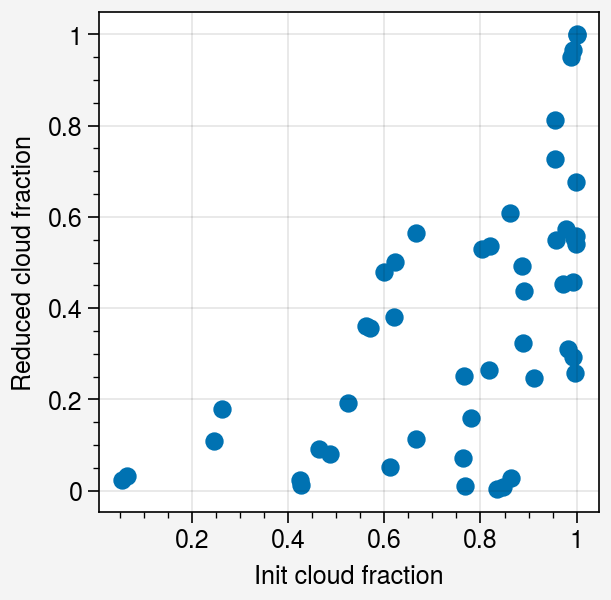

In [390]:
fig, ax = pplt.subplots()
test = example_results.loc[example_results.t1t2 == '200_190']
ax.scatter(test.cloud_fraction, test.cloud_fraction*test.delta_cf) 
ax.format(xlabel='Init cloud fraction', ylabel='Reduced cloud fraction')

In [398]:
sea_ice_fraction_loss_function??

Signature: sea_ice_fraction_loss_function(new_mask, sea_ice_labels)
Source:   
def sea_ice_fraction_loss_function(new_mask, sea_ice_labels):
    """Relative decrease in sea ice cover from ground truth (sea_ice_labels) to the new_mask.
    If no sea ice, return 0"""

    sea_ice = np.sum(sea_ice_labels > 0)
    if sea_ice == 0:
        return 0

    uncovered_ice = np.sum((sea_ice_labels > 0) & ~new_mask)
    return (sea_ice - uncovered_ice)/sea_ice
File:      /var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_65967/417530098.py
Type:      function

In [335]:
r_upper = 0.25 # 0 = Only using t1 and t2
example_results = []
for case in df_training.index:
    for t1 in range(50, 205, 5):
        for t2 in range(100, 255, 5):
            clouds_view, cloud_mask = generate_masks(fc_images[case], t1=t1, t2=t2, r_lower=0, r_upper=r_upper, tc=tc)
            manual_floe_labels = lb_images[case][0,:,:]
        
            delta_cf = cloud_fraction_loss_function(cloud_mask, clouds_view)
            delta_si = sea_ice_fraction_loss_function(cloud_mask, manual_floe_labels)
            mean_error = (clouds_view & (manual_floe_labels == 0)) != cloud_mask
            example_results.append([case, tc, t1, t2, r_upper, delta_cf, delta_si, np.mean(mean_error)])
example_results_r25 = pd.DataFrame(example_results, columns=['case', 'tc', 't_1', 't_2', 'ratio', 'delta_cf', 'delta_si', 'mean_error'])

/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_65967/1523296688.py:6: RuntimeWarning: divide by zero encountered in divide
  mask_ratio = fc_image[0,:,:]/fc_image[1,:,:]
/var/folders/_1/dv6d0pjn20bgy9ysl0pfsbr40000gn/T/ipykernel_65967/1523296688.py:6: RuntimeWarning: invalid value encountered in divide
  mask_ratio = fc_image[0,:,:]/fc_image[1,:,:]


In [340]:
example_results_r25['t1t2'] = [str(x) + '_' + str(y) for x, y in zip(example_results_r25.t_1, example_results_r25.t_2)]

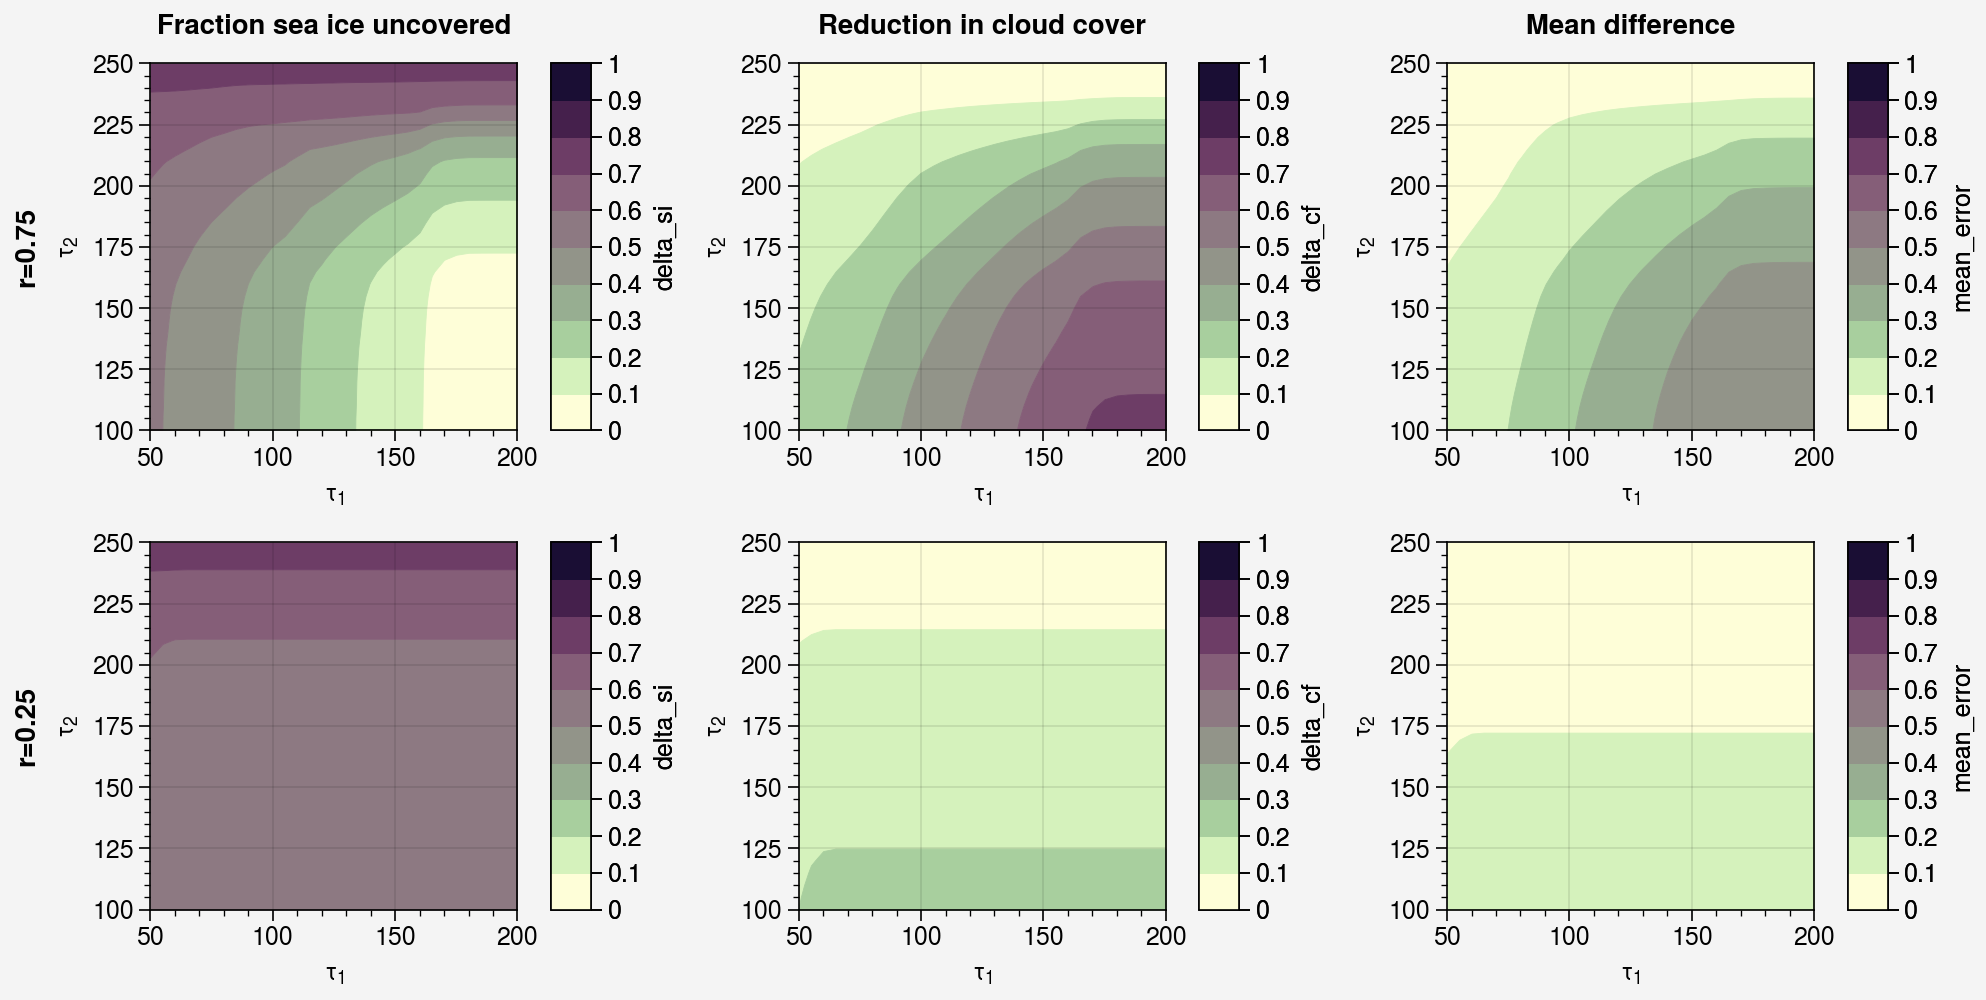

In [352]:
fig, axs = pplt.subplots(height=5, ncols=3, nrows=2, share=False)
data = example_results[['t_1', 't_2', 'delta_cf', 'delta_si', 'mean_error', 't1t2']].groupby('t1t2').mean()
# data = data.where(data.delta_cf <= 0.2)
for ax, var in zip(axs[0,:], ['delta_si', 'delta_cf', 'mean_error']):
    c=ax.contourf(data.pivot_table(index='t_2', columns='t_1', values=var), cmap='tokyo_r', vmin=0, vmax=1)
    ax.colorbar(c, label=var)
    ax.format(ylabel='$\\tau_2$')
    ax.format(xlabel='$\\tau_1$')

data = example_results_r25[['t_1', 't_2', 'delta_cf', 'delta_si', 'mean_error', 't1t2']].groupby('t1t2').mean()

for ax, var in zip(axs[1,:], ['delta_si', 'delta_cf', 'mean_error']):
    c=ax.contourf(data.pivot_table(index='t_2', columns='t_1', values=var), cmap='tokyo_r', vmin=0, vmax=1)
    ax.colorbar(c, label=var)
    ax.format(ylabel='$\\tau_2$')
    ax.format(xlabel='$\\tau_1$')

axs.format(leftlabels=['r=0.75', 'r=0.25'], toplabels=['Fraction sea ice uncovered', 'Reduction in cloud cover', 'Mean difference'])

Metrics for the "thin cloud identification" step. 
1. Quantify the reduction in cloud cover (what we want to minimize). Pixels where there were clouds, the clouds were removed, and no ice floe is visible. $CF_{all}$ and $CF_{thin}$ and not $SI$.
2. Quantify the increase in sea ice floe visibility. Pixels where there were clouds, the clouds were removed, and an ice floe is visible. $CF_{all}$ and $CF_{thin}$ and $SI$.

Interpretation: the pixels with ratio less than a give amount are removed from the cloud mask as likely containing sea ice. So with a high ratio, only the T1 and T2 thresholds are limiting anything. Lower ratios result in larger numbers of cloud pixels being masked.

These are not adjusted for the number of sea ice pixels.